In [1]:
import yaml
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from hyperparam_scan_util import GridData
pd.set_option('display.max_columns', None)

In [2]:
data = GridData.load_or_create(version=1, backup=False)

In [3]:
def get_trials_df(data: GridData):
    trials = []
    for trial in data.trials.values():
        trial_dict = {
            "index": trial.index,
            "duration": trial.duration,
            "error": trial.error,
        }

        for key, value in trial.config.items():
            trial_dict[f"config.{key}"] = value

        for key, value in trial.metrics.items():
            if key == "epochs":
                continue
            trial_dict[f"metrics.{key}"] = value

        trials.append(trial_dict)

    return pd.DataFrame(trials)

trials_df = get_trials_df(data)
trials_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Columns: 116 entries, index to metrics.silent_neurons_first_max_std
dtypes: float64(101), int64(13), object(2)
memory usage: 4.7+ KB


In [4]:
# def load_trials_df(version: int):
#     filename = f"grid_data_{version:02d}.yaml"

#     with open(filename, "r") as f:
#         data = yaml.safe_load(f)

#     trials = []

#     for trial in data["trials"].values():
#         for k, v in trial["config"].items():
#             trial[f"config.{k}"] = v
#         del trial["config"]

#         for k, v in trial["metrics"].items():
#             trial[f"metrics.{k}"] = v
#         del trial["metrics"]

#         trials.append(trial)

#     return pd.DataFrame(trials)

# trials_df = load_trials_df(version=1)
# trials_df.info()

AttributeError: '' is not a valid function for 'DataFrameGroupBy' object

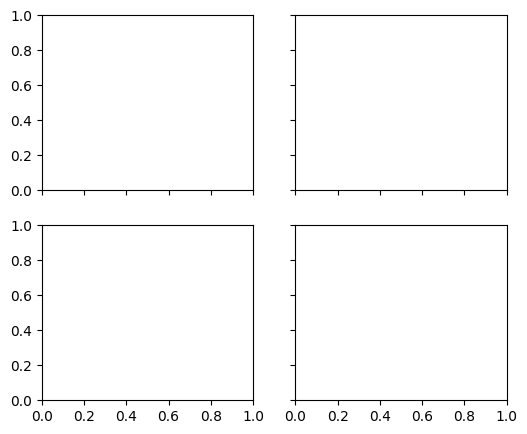

In [5]:
def plot_config_dependency(df, agg_funcs=("max",), agg_kwargs=dict(numeric_only=True)):
    config_cols = [
        col
        for col in df.columns
        if col.startswith("config.") and df[col].nunique() > 1
    ]

    fig, axs = plt.subplots(2, len(config_cols), figsize=(3 * len(config_cols), 5), sharey="row", sharex="col", squeeze=False)

    for (agg_ax, count_ax), config_col in zip(axs.T, config_cols):
        grouped = df.groupby(config_col)

        for agg_func in agg_funcs:
            agg_df = grouped.aggregate(agg_func, **agg_kwargs)
            
            agg_df.plot(
                ax=agg_ax,
                y="metrics.acc_max_mean",
                marker=".",
                linestyle="--",
                label=agg_func,
            )

        grouped.count().plot(
            ax=count_ax,
            y="metrics.acc_max_mean",
            marker=".",
            linestyle="--",
            label="success",
            color="green",
        )
        grouped.count().plot(
            ax=count_ax,
            y="error",
            marker=".",
            linestyle="--",
            label="error",
            color="red",
        )
        grouped.size().plot(
            ax=count_ax,
            marker=".",
            linestyle="--",
            label="total",
            color="black",
        )

        agg_ax.set_ylabel("Accuracy")
        agg_ax.grid()
        agg_ax.legend()

        count_ax.set_xlabel(config_col.removeprefix("config."))
        count_ax.set_ylabel("Trial count")
        count_ax.grid()
        count_ax.legend()

    plt.tight_layout()
    plt.show()

plot_config_dependency(trials_df)

## Best trials

In [ ]:
trials_df.sort_values("metrics.acc_mean", ascending=False).head(10)

KeyError: 'metrics.acc_mean'

In [ ]:
best_trial = trials_df.loc[trials_df["metrics.acc_mean"].idxmax()]
print("===== BEST TRIAL =====")
print(best_trial)
print()
print("===== BEST CONFIG =====")
best_config = {
    k.removeprefix("config."): v.item()
    for k, v in best_trial.items()
    if isinstance(k, str) and k.startswith("config.")
}
best_config

===== BEST TRIAL =====
index                                                         163
n_samples                                                       3
started_at                             2024-08-28_22-31-08_896511
finished_at                            2024-08-28_22-32-06_129337
duration                                                57.232826
error                                                        None
config.Nt                                                       8
config.Nin                                                   5600
config.p_flip                                                 0.0
config.K                                                      150
config.Nlayer                                                   2
config.Nhidden                                                 80
config.Nin_virtual                                             12
metrics.acc_mean                                         0.832983
metrics.acc_std                                      

{'Nt': 8,
 'Nin': 5600,
 'p_flip': 0.0,
 'K': 150,
 'Nlayer': 2,
 'Nhidden': 80,
 'Nin_virtual': 12}